## Transformer with IMDB example

+ 먼저 케라스에서 제공하고 있는 MultiHeadAttention Layer를 직접 정의해봅니다.

## Setup

In [ ]:
import tensorflow as tf

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, GlobalAveragePooling1D, Dropout, Dense
from tensorflow.keras.models import Model

### MultiHeadAttention Layer 정의하기
+ 기본 Attention Layer는 다음 이미지처럼 정의합니다.

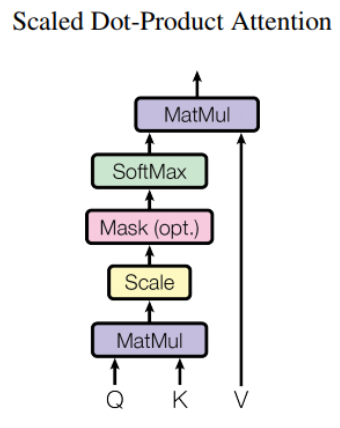

In [ ]:
class Attention_Layer(tf.keras.layers.Layer):
      def __init__(self):
        super(Attention_Layer, self).__init__()
        self.softmax_layer = tf.keras.layers.Softmax(axis = -1)

      def call(self, query, key, value, mask = None):
        self.query = query # (batch_size, num_heads, seq_len // num_heads, dim)
        self.key = key     # (batch_size, num_heads, seq_len // num_heads, dim)
        self.value = value # (batch_size, num_heads, seq_len // num_heads, dim)

        # 1. Q와 K를 matmul합니다.
        # (batch_size, num_heads, seq_len // num_heads, seq_len // num_heads)
        matmul_qk = tf.matmul(self.query, self.key, transpose_b = True) # (batch_size, Tq, Tv)

        # 2. Scale을 적용
        dk = tf.cast(tf.shape(self.key)[-1], tf.float32)
        scaled_matmul_qk = matmul_qk / tf.math.sqrt(dk)

        # 2'. mask 적용
        if mask is not None:
          scaled_matmul_qk += (mask * -1e9)

        # 3. softmax 함수를 적용합니다.
        # (batch_size, num_heads, seq_len // num_heads, seq_len // num_heads)     
        attention_weights = self.softmax_layer(scaled_matmul_qk)

        # 4. Value랑 Matmul합니다.
        # (batch_size, num_heads, seq_len // num_heads, dim)
        output = tf.matmul(attention_weights, self.value) # (batch_size, Tq, dim)

        return output, attention_weights

+ 위에서 정의한 Attention Layer를 사용해서 MultiHead Attention Layer를 정의해봅니다.

In [ ]:
class MultiHeadAttention_Layer(tf.keras.layers.Layer):
    def __init__(self, num_heads, key_dim):
        super(MultiHeadAttention_Layer, self).__init__()
        self.num_heads = num_heads
        self.key_dim = key_dim
        self.depth = key_dim // num_heads
        
        self.att = Attention_Layer()
        
        self.wq = tf.keras.layers.Dense(key_dim)
        self.wk = tf.keras.layers.Dense(key_dim)
        self.wv = tf.keras.layers.Dense(key_dim)

        
        self.final_dense = tf.keras.layers.Dense(key_dim)
        
    def split_heads(self, x, batch_size):
        '''
            (batch_size, num_heads, key_dim) --> (batch_size, num_heads, seq_len, key_dim)
        '''
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm = [0, 2, 1, 3])

    def call(self, query, value, mask):
        batch_size = tf.shape(query)[0]

        q = self.wq(query) # (batch_size, seq_len, key_dim)
        k = self.wk(value) # (batch_size, seq_len, key_dim)
        v = self.wv(value) # (batch_size, seq_len, key_dim)
        
        q = self.split_heads(q, batch_size) # (batch_size, num_heads, seq_len // num_heads, depth)
        k = self.split_heads(k, batch_size) # (batch_size, num_heads, seq_len // num_heads, depth)
        v = self.split_heads(v, batch_size) # (batch_size, num_heads, seq_len // num_heads, depth)

        # scaled_attention: (batch_size, num_heads, seq_len_q, key_dim)
        # attention_weights: (batch_size, num_heads, seq_len_q, seq_len // num_heads)
        scaled_attention, attention_weights = self.att(q, k, v, mask)
        # (batch_size, seq_len_q, num_heads, key_dim)
        scaled_attention = tf.transpose(scaled_attention, perm = [0, 2, 1, 3])
        # (batch_size, seq_len_q, key_dim)
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.key_dim)) 
        
        # (batch_size, seq_len_q, key_dim)
        output = self.final_dense(concat_attention)

        return output, attention_weights

## Transformer Block 만들기

In [ ]:
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate = 0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention_Layer(num_heads = num_heads, key_dim = embed_dim)
        self.ffn = tf.keras.Sequential([tf.keras.layers.Dense(ff_dim, activation = 'relu'),
                                       tf.keras.layers.Dense(embed_dim)])
        
        self.layernorm_1 = tf.keras.layers.LayerNormalization(epsilon = 1e-6)
        self.layernorm_2 = tf.keras.layers.LayerNormalization(epsilon = 1e-6)
        self.dropout_1 = tf.keras.layers.Dropout(rate)
        self.dropout_2 = tf.keras.layers.Dropout(rate)
        
    def call(self, inputs, mask, training):
        # inputs: (batch_size, seq_len, emb_dim)
        attn_output, _ = self.att(inputs, inputs, mask)
        attn_output = self.dropout_1(attn_output, training = training)
        out1 = self.layernorm_1(inputs + attn_output)
        
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout_2(ffn_output, training = training)
        
        return self.layernorm_2(out1 + ffn_output)

## Position Embedding 만들기 

In [ ]:
class PositionEmbedding(tf.keras.layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(PositionEmbedding, self).__init__()
        self.token_emb = tf.keras.layers.Embedding(input_dim = vocab_size, output_dim = embed_dim)
        self.pos_emb = tf.keras.layers.Embedding(input_dim = maxlen, output_dim = embed_dim)
        
    def call(self, x):
        max_len = tf.shape(x)[-1]
        positions = tf.range(start = 0, limit = max_len, delta = 1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        
        return x + positions

## IMDB dataset 가져오기 

In [ ]:
vocab_size = 10000
max_len = 200

(x_train, y_train), (x_val, y_val) = tf.keras.datasets.imdb.load_data(num_words = vocab_size)
x_train = pad_sequences(x_train, maxlen = max_len)
x_val = pad_sequences(x_val, maxlen = max_len)

In [ ]:
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)

    # add extra dimensions to add the padding
    # to the attention logits.
    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

mask_train = create_padding_mask(x_train)

## Model 구성하기

In [ ]:
embed_dim = 32
num_heads = 2
ff_dim = 32

inputs = Input(shape = (max_len, ))
mask_inputs = Input(shape = (1, 1, max_len))

embedding_layer = PositionEmbedding(max_len, vocab_size, embed_dim)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)

x = embedding_layer(inputs) # (batch_size, max_len, embed_dim)
x = transformer_block(x, mask_inputs, training = True)
x = GlobalAveragePooling1D()(x)
x = Dropout(0.1)(x)
x = Dense(20, activation = 'relu')(x)
x = Dropout(0.1)(x)
outputs = Dense(2, activation = 'softmax')(x)

model = Model(inputs = [inputs, mask_inputs], outputs = outputs)

In [ ]:
model.compile("adam", "sparse_categorical_crossentropy", metrics=["accuracy"])
model.fit([x_train, mask_train], y_train, batch_size = 32, epochs = 2,)